# Knowledge graph experiment data generation

In [27]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [90]:
n_nodes = 50
n_relations = 5

node_vocab = [f'N{i}' for i in range(n_nodes)]
relation_vocab = [f'R{i}' for i in range(n_relations)]
special_tokens = ['<CTX>', '</CTX>', '<SEP>', '<QUERY>', '</QUERY>', '<EOS>', '<PAD>', '<UNK>']
vocab = node_vocab + relation_vocab + special_tokens
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}

In [91]:
# randomly generate a graph

# graph parameters
radiuses = [0.2]* n_relations
dims = [2] * n_relations # 2 for now to make it easy to visualize

# generate graph for each relation
# i'm using random geometric graph for now
# roughly, my thinking is that this may correspond to some more "interesting" type of relation which encodes a transitivity property
# we can think about generating this in different ways later
graphs = [nx.random_geometric_graph(n=node_vocab, radius=radiuses[i], dim=dims[i], p=2) for i in range(n_relations)]

# we transform to a DAG

def to_directed(graph):
    graph = graph.to_directed()

    def violate_direction(edge):
        a = int(edge[0][1:])
        b = int(edge[1][1:])
        return a >= b
    edges_to_remove = [edge for edge in graph.edges if violate_direction(edge)]

    graph.remove_edges_from(edges_to_remove )

    return graph

graphs = [to_directed(graph) for graph in graphs]


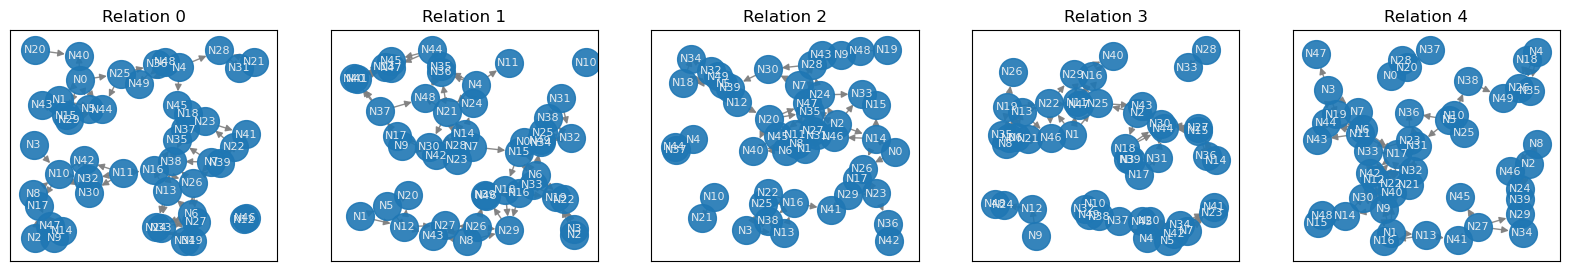

In [92]:
rel = 0

# visualize graphs
fig, axs = plt.subplots(ncols=n_relations, figsize=(4*n_relations,3))
options = {"edge_color": "tab:gray", "node_size": 400, "alpha": 0.9, "node_color": "tab:blue", "font_color": "whitesmoke", "font_size": 8}
for rel in range(n_relations):
    pos = nx.get_node_attributes(graphs[rel], 'pos')
    nx.draw_networkx(graphs[rel], pos=pos, **options, ax=axs[rel])
    axs[rel].set_title(f"Relation {rel}");

In [93]:
facts = {rel: list(graphs[rel].edges) for rel in range(n_relations)}

In [77]:
def sample_fact(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)
    # sample fact
    fact_idx = np.random.choice(len(facts[rel]))
    fact = facts[rel][fact_idx]
    n1, n2 = fact
    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]

def sample_falsehood(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)

    while True:
        # sample falsehood
        n1, n2 = np.random.choice(node_vocab, size=2)
        if (n1, n2) not in facts[rel]:
            break

    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]


In [97]:
# generate context of true but irrelevant facts
def generate_robustness_example(context_length, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_fact(return_idx=return_idx)

    for i in range(context_length):
        # NOTE: for now, not checking if irrelevant; sampling randomly so most likely irrelevant
        ctx_fact = sample_fact(return_idx=return_idx)
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [99]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_robustness_example(3, return_idx=False))

<CTX> N19 R2 N3 <SEP> N8 R2 N45 <SEP> N27 R4 N41 <SEP> </CTX> <QUERY> N19 R2 N3 </QUERY> <EOS>
<CTX> N13 R4 N21 <SEP> N24 R2 N47 <SEP> N12 R2 N39 <SEP> </CTX> <QUERY> N13 R4 N21 </QUERY> <EOS>
<CTX> N37 R1 N41 <SEP> N5 R1 N12 <SEP> N8 R2 N32 <SEP> </CTX> <QUERY> N8 R2 N32 </QUERY> <EOS>
<CTX> N14 R3 N19 <SEP> N1 R2 N35 <SEP> N15 R0 N44 <SEP> </CTX> <QUERY> N14 R3 N19 </QUERY> <EOS>
<CTX> N8 R2 N46 <SEP> N44 R0 N9 <SEP> N18 R0 N37 <SEP> </CTX> <QUERY> N44 R0 N9 </QUERY> <EOS>


In [103]:
# query is inconsistent with world knowledge
def generate_controllability_example(context_length, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_falsehood(return_idx=return_idx)

    contexts = []
    for i in range(context_length-1):
        ctx_fact = sample_fact(return_idx=return_idx)
        contexts.append(ctx_fact)

    # insert query fact at random position of context to test controllability
    insert_pos = np.random.randint(context_length)
    contexts.insert(insert_pos, query_fact)

    for ctx_fact in contexts:
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [104]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_controllability_example(3, return_idx=False))

<CTX> N11 R3 N29 <SEP> N7 R0 N39 <SEP> N16 R3 N19 <SEP> </CTX> <QUERY> N16 R3 N19 </QUERY> <EOS>
<CTX> N14 R3 N27 <SEP> N0 R4 N28 <SEP> N29 R1 N14 <SEP> </CTX> <QUERY> N29 R1 N14 </QUERY> <EOS>
<CTX> N2 R2 N33 <SEP> N14 R1 N23 <SEP> N7 R1 N8 <SEP> </CTX> <QUERY> N7 R1 N8 </QUERY> <EOS>
<CTX> N39 R3 N34 <SEP> N1 R1 N12 <SEP> N21 R1 N30 <SEP> </CTX> <QUERY> N39 R3 N34 </QUERY> <EOS>
<CTX> N17 R4 N23 <SEP> N30 R3 N44 <SEP> N45 R4 N13 <SEP> </CTX> <QUERY> N45 R4 N13 </QUERY> <EOS>


In [105]:
# print some examples of robustness examples (print token idx)
for _ in range(5):
    print(generate_controllability_example(3, return_idx=True))

[55, 39, 52, 32, 57, 4, 51, 35, 57, 1, 51, 12, 57, 56, 58, 39, 52, 32, 59, 60]
[55, 6, 51, 15, 57, 4, 54, 18, 57, 2, 53, 19, 57, 56, 58, 2, 53, 19, 59, 60]
[55, 1, 52, 31, 57, 21, 50, 31, 57, 16, 52, 19, 57, 56, 58, 16, 52, 19, 59, 60]
[55, 27, 53, 30, 57, 7, 52, 28, 57, 19, 54, 28, 57, 56, 58, 19, 54, 28, 59, 60]
[55, 20, 54, 32, 57, 15, 51, 18, 57, 32, 54, 42, 57, 56, 58, 20, 54, 32, 59, 60]
